In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
plt.rc('axes',labelsize=14)
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)
import warnings
warnings.filterwarnings("ignore")

In [2]:
import struct
#两个数据加载函数：
def loadimageset(filename):
    binfile = open(filename,'rb')
    buffers = binfile.read()
    head = struct.unpack_from('>IIII',buffers,0)
    offset = struct.calcsize('>IIII')
    imgnum = head[1]
    width = head[2]
    height = head[3]
    bits = imgnum * width * height
    bitsstring = '>' + str(bits) + 'B'
    imgs = struct.unpack_from(bitsstring,buffers,offset)
    binfile.close()
    imgs = np.reshape(imgs,[imgnum,width*height])
    return imgs
def loadlabels(filename):
    binfile = open(filename,'rb')
    buffers = binfile.read()
    head = struct.unpack_from('>II',buffers,0)
    offset = struct.calcsize('>II')
    labelnum = head[1]
    numstring = '>' + str(labelnum) + 'B'
    labels = struct.unpack_from(numstring,buffers,offset)
    binfile.close()
    labels = np.reshape(labels,[labelnum])
    return labels

In [3]:
train_data_file = 'datasets/train-images.idx3-ubyte'
train_labels_file = 'datasets/train-labels.idx1-ubyte'
test_data_file = 'datasets/t10k-images.idx3-ubyte'
test_labels_file = 'datasets/t10k-labels.idx1-ubyte'

In [4]:
X_train,X_test,y_train,y_test = loadimageset(train_data_file),loadimageset(test_data_file),\
    loadlabels(train_labels_file),loadlabels(test_labels_file)

In [5]:
shuffle_index = np.random.permutation(len(X_train))
X_train,y_train = X_train[shuffle_index],y_train[shuffle_index]

In [6]:
y_train_5, y_test_5 = (y_train == 5), (y_test == 5)
y_train_5, y_test_5 = y_train_5.astype(np.int32), y_test_5.astype(np.int32)

In [7]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [9]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [10]:
from sklearn.metrics import confusion_matrix

In [11]:
confusion_matrix(y_train_5,y_train_pred)

array([[53472,  1107],
       [ 1216,  4205]], dtype=int64)

In [12]:
pd.crosstab(y_train_5,y_train_pred)

col_0,0,1
row_0,,
0,53472,1107
1,1216,4205


In [13]:
from sklearn.metrics import precision_score,recall_score

In [14]:
precision_score(y_train_5,y_train_pred)

0.7916039156626506

In [15]:
recall_score(y_train_5,y_train_pred)

0.7756871425936174

In [16]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7835647069784776

In [17]:
some_digit,some_label = X_train[[5],:],y_train_5[5]

In [18]:
from sklearn.linear_model import SGDClassifier

In [19]:
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [20]:
sgd_clf.decision_function(X_train)

array([-10372.71409364, -20319.06317229,  -2008.24107923, ...,
        -8682.1196752 ,  -2023.44336134, -12448.23454924])

In [21]:
y_train_pred_score = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method='decision_function')

In [22]:
from sklearn.metrics import precision_recall_curve
precisions,recalls,thresholds = precision_recall_curve(y_train_5,y_train_pred_score)

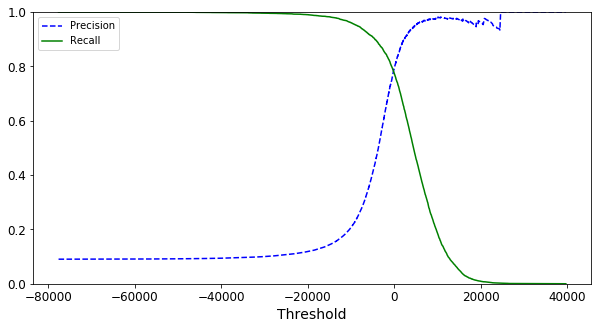

In [23]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.figure(figsize=(10,5))
    plt.plot(thresholds,precisions[:-1],'b--',label='Precision')
    plt.plot(thresholds,recalls[:-1],'g-',label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)

In [24]:
precisions.shape,recalls.shape,thresholds.shape

((59853,), (59853,), (59852,))